In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scikitplot as skplt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler, power_transform
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pyfiglet

In [2]:
df = pd.read_excel("C:/Users/Jeet Sarkar/Data Science PG Program/Data_Train.xlsx")
df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [3]:
df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [4]:
df.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

We have only two missing values 1 is Route and 2 is in Total stops. Let's impute the missing values.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


We have only column whcich contains numeric data and this column is a target column.

# Preprocessing

1-Doing feature engineering

2-Filling missing values

3-Droping some columns

Dropping Route, it is not important because we just want to predict the price so basically we need Source and destination and also Droping additional info because it is not important for flight fare prediction and also dropping Date of journey because i will converte that into years,month,day and also dropping duration because if we have Dep_time and Arrival_time we dont need it because it just represent the difference between these two only

In [6]:
def preprocess1(df):
    df=df.copy()
    df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])
    df['Year_of_Journey'] = df['Date_of_Journey'].dt.year
    df['Month_of_Journey'] = df['Date_of_Journey'].dt.month
    df['Day_of_Journey'] = df['Date_of_Journey'].dt.day
    df['Total_Stops'] = df['Total_Stops'].fillna(df['Total_Stops'].mode()[0])   # Imputing the missing values
    df=df.drop(['Date_of_Journey','Route','Duration'], axis=1)
    return df

In [7]:
df = preprocess1(df)

In [8]:
df

,Airline,Source,Destination,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,Year_of_Journey,Month_of_Journey,Day_of_Journey
0,IndiGo,Banglore,New Delhi,22:20,01:10 22 Mar,non-stop,No info,3897,2019,3,24
1,Air India,Kolkata,Banglore,05:50,13:15,2 stops,No info,7662,2019,1,5
2,Jet Airways,Delhi,Cochin,09:25,04:25 10 Jun,2 stops,No info,13882,2019,9,6
3,IndiGo,Kolkata,Banglore,18:05,23:30,1 stop,No info,6218,2019,12,5
4,IndiGo,Banglore,New Delhi,16:50,21:35,1 stop,No info,13302,2019,1,3
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,19:55,22:25,non-stop,No info,4107,2019,9,4
10679,Air India,Kolkata,Banglore,20:45,23:20,non-stop,No info,4145,2019,4,27
10680,Jet Airways,Banglore,Delhi,08:20,11:20,non-stop,No info,7229,2019,4,27
10681,Vistara,Banglore,New Delhi,11:30,14:10,non-stop,No info,12648,2019,1,3


In [9]:
def preprocess2(df):
    df['Dep_Hour'] = pd.to_datetime(df['Dep_Time']).dt.hour
    df['Dep_Minute'] = pd.to_datetime(df['Dep_Time']).dt.minute
    df=df.drop(['Dep_Time'], axis=1)
    df['Arrival_Hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
    df['Arrival_Minute'] = pd.to_datetime(df['Arrival_Time']).dt.minute
    df=df.drop(['Arrival_Time'], axis=1)
    return df

In [10]:
df = preprocess2(df)

In [11]:
df

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Year_of_Journey,Month_of_Journey,Day_of_Journey,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute
0,IndiGo,Banglore,New Delhi,non-stop,No info,3897,2019,3,24,22,20,1,10
1,Air India,Kolkata,Banglore,2 stops,No info,7662,2019,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,2 stops,No info,13882,2019,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,1 stop,No info,6218,2019,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,1 stop,No info,13302,2019,1,3,16,50,21,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,non-stop,No info,4107,2019,9,4,19,55,22,25
10679,Air India,Kolkata,Banglore,non-stop,No info,4145,2019,4,27,20,45,23,20
10680,Jet Airways,Banglore,Delhi,non-stop,No info,7229,2019,4,27,8,20,11,20
10681,Vistara,Banglore,New Delhi,non-stop,No info,12648,2019,1,3,11,30,14,10


In [12]:
def countplot(x):
    plt.figure(figsize=(12,10))
    sns.countplot(x)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize=10)
    return plt.show()

### Countplot of Airlines

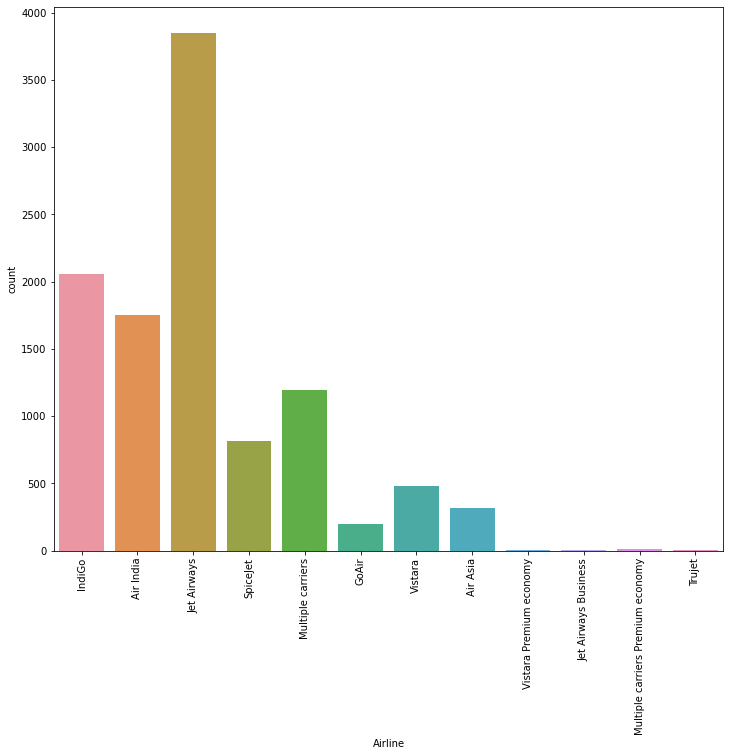

In [13]:
countplot(df['Airline'])

## Obseravtion

1- we can see that mostly people use to travel with **Jet Airways**

2- After Jet Airways people use to travel with **IndiGo**

3-And GoAir has the least count why i am saying least count because Vistara,Jet Airways,MCPE,Trujet has no count

### Countplot of Source

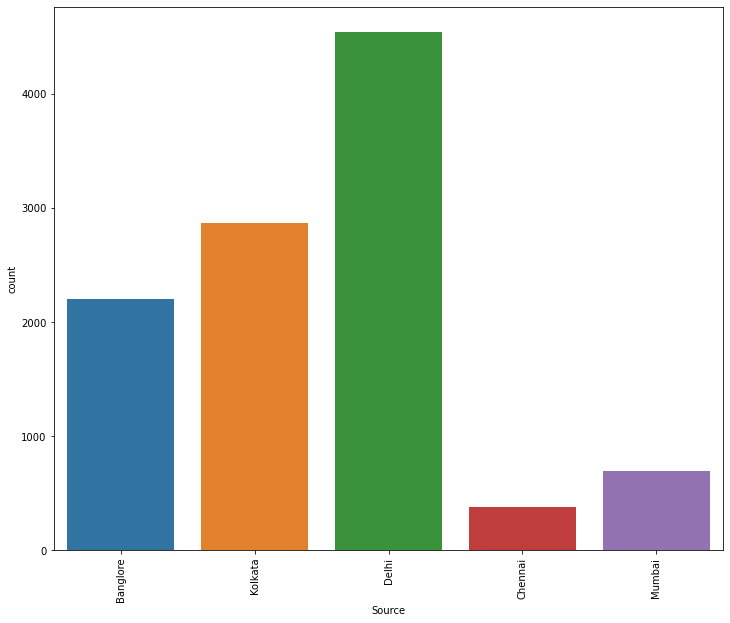

In [14]:
countplot(df['Source'])

## Obseravtion

1-We can see that mostly Source has Delhi as higher the others

2- After Delhi kolkata has 2nd high count

3-And at least chennai has very less people source is chennai

### Countplot of Destination

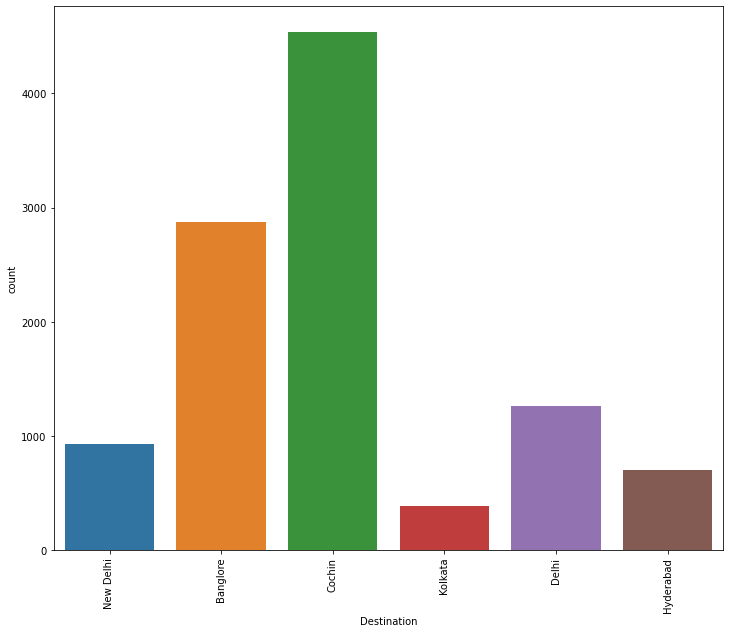

In [15]:
countplot(df['Destination'])

## Obseravtion

1-we can see that mostly people use to go Cochin as per the data shows

2-After Cochin people use to go to Banglore

3-And very less people use to go to Kolkata

### Countplot of Total_Stops

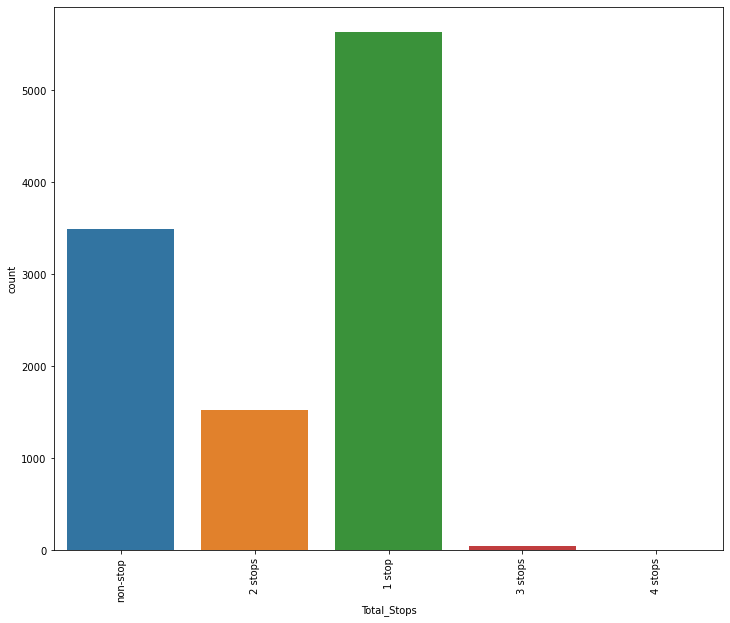

In [16]:
countplot(df['Total_Stops'])

### Obseravtion

1-We can see that mostly people use to take a flight who has only one stop

2-After one stop people used to take non-stop flights

3-ANd only approx 1500 people use to take 2 stop flights

4-ANd there are very less people who used to take 3 stops or 4 stops flight

### Countplot of Year_of_Journey

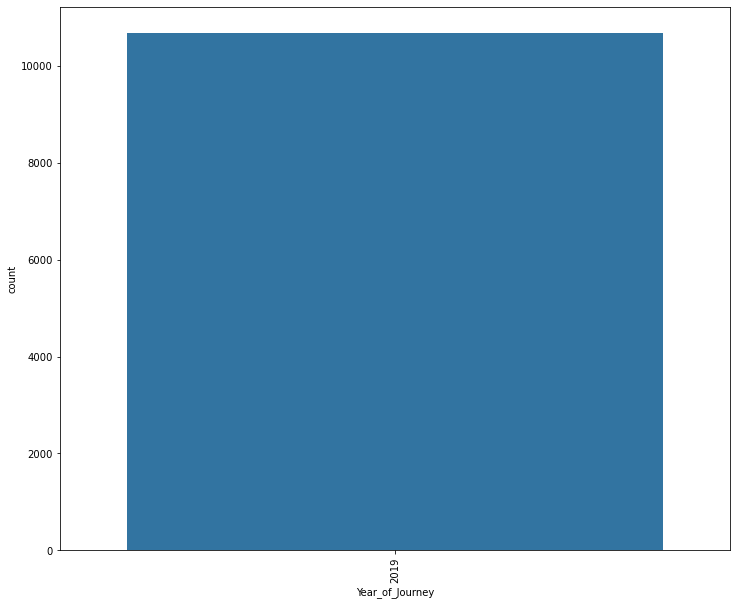

In [17]:
countplot(df['Year_of_Journey'])

### Observation

1- We have only 2019 year data

### Countplot of Month_of_Journey

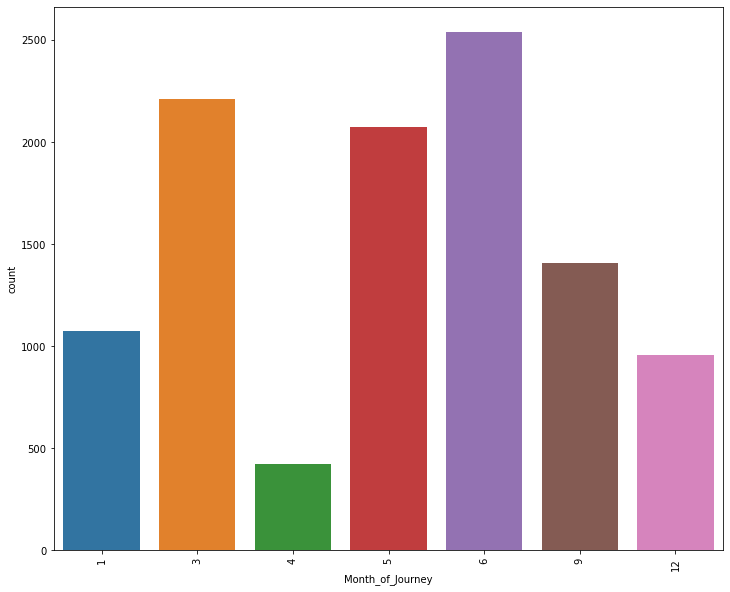

In [18]:
countplot(df['Month_of_Journey'])

## Obseravtion

1-From above graph i can say that mostly people use to take flights in 6th month maybe because children holiday start in 3rd month thats why 3rd month has the 2nd high count so holidays ends in 5th or 6th month so parents with child used to return there home or to school thats why 5th month also has the 3rd high count

2-and 4th has the least count because people use to take less flight in 4th month may be becouse financial year closing

3-And in 12th and 9th month people also use to take less flight or used to travel less as compare to 6th,5th and 3rd month

### Countplot of Additional_Info

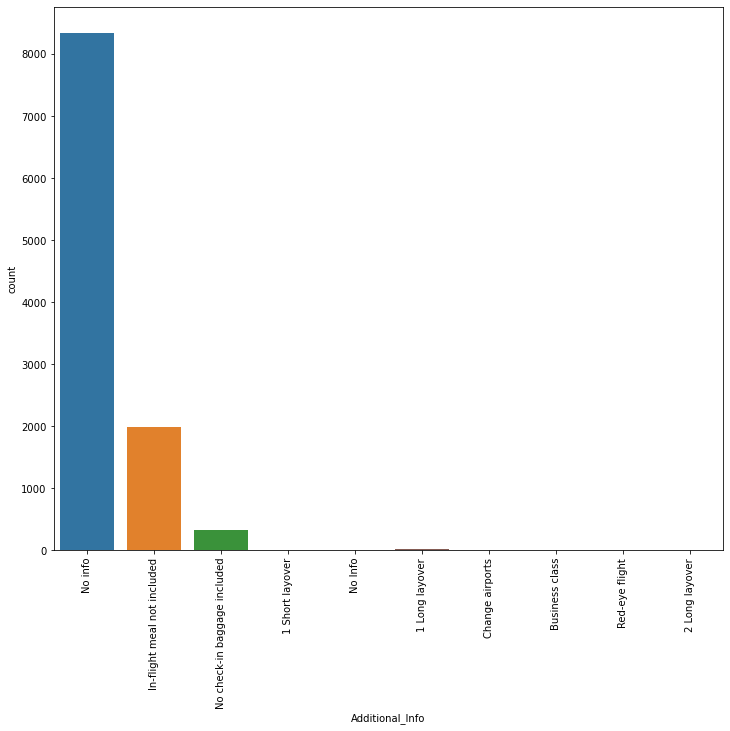

In [19]:
countplot(df['Additional_Info'])

## Obseravtion 

1-From above graph i can say that mostly information that is available is no_info

2-and approx 2k people have problem with no meal is included in flight this problem may occur because people have booked a cheap flight still they want meal which is not possible

3-people have also said that there is no check in baggage included

(array([ 4000.,  5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000.,
        12000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

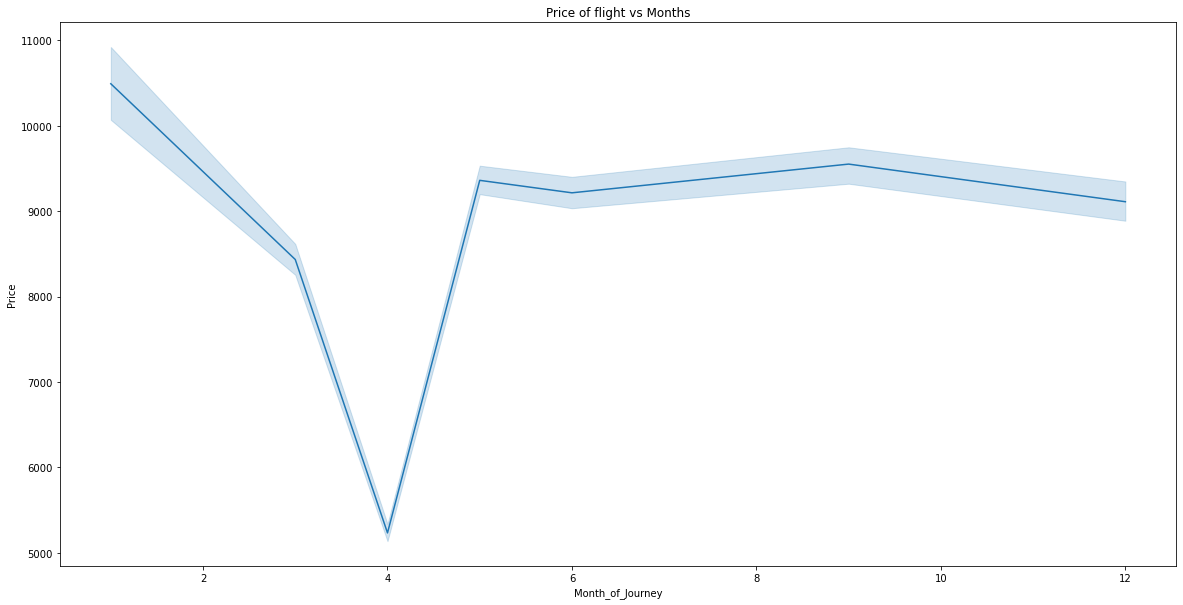

In [20]:
plt.figure(figsize=(20,10))
sns.lineplot(x='Month_of_Journey', y='Price', data=df)
plt.title('Price of flight vs Months')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

<AxesSubplot:xlabel='Month_of_Journey', ylabel='count'>

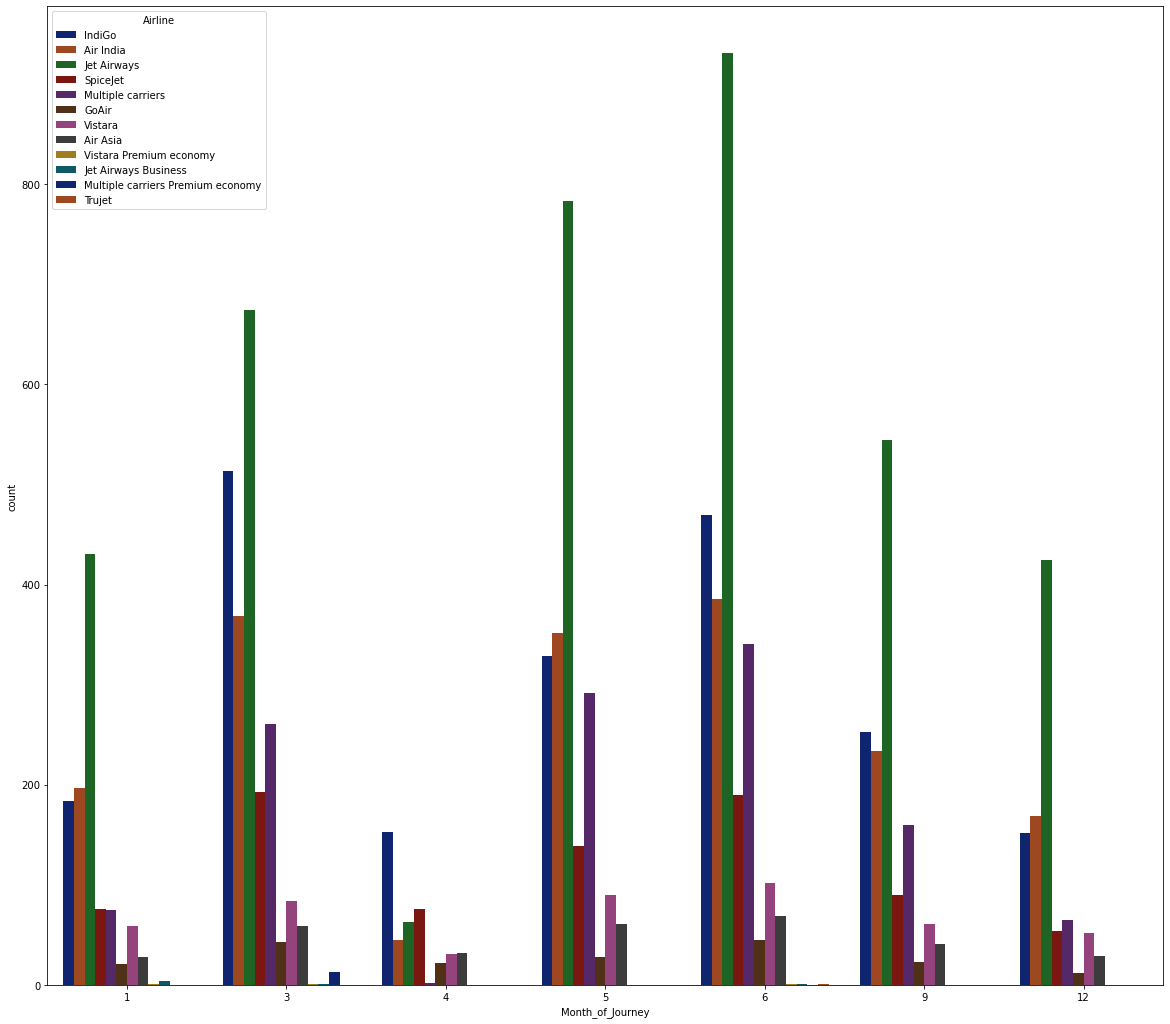

In [21]:
plt.figure(figsize=(20,18))
sns.countplot('Month_of_Journey', hue='Airline', data=df, palette='dark')

### Observation

1- From above graph we can see that in the year of 2019 mostly people used to travel in jet airways may be becouse jet airways gives good offers to customers.

2 - After jet airways mostly people used IndiGo.

(array([    0., 10000., 20000., 30000., 40000., 50000., 60000., 70000.,
        80000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

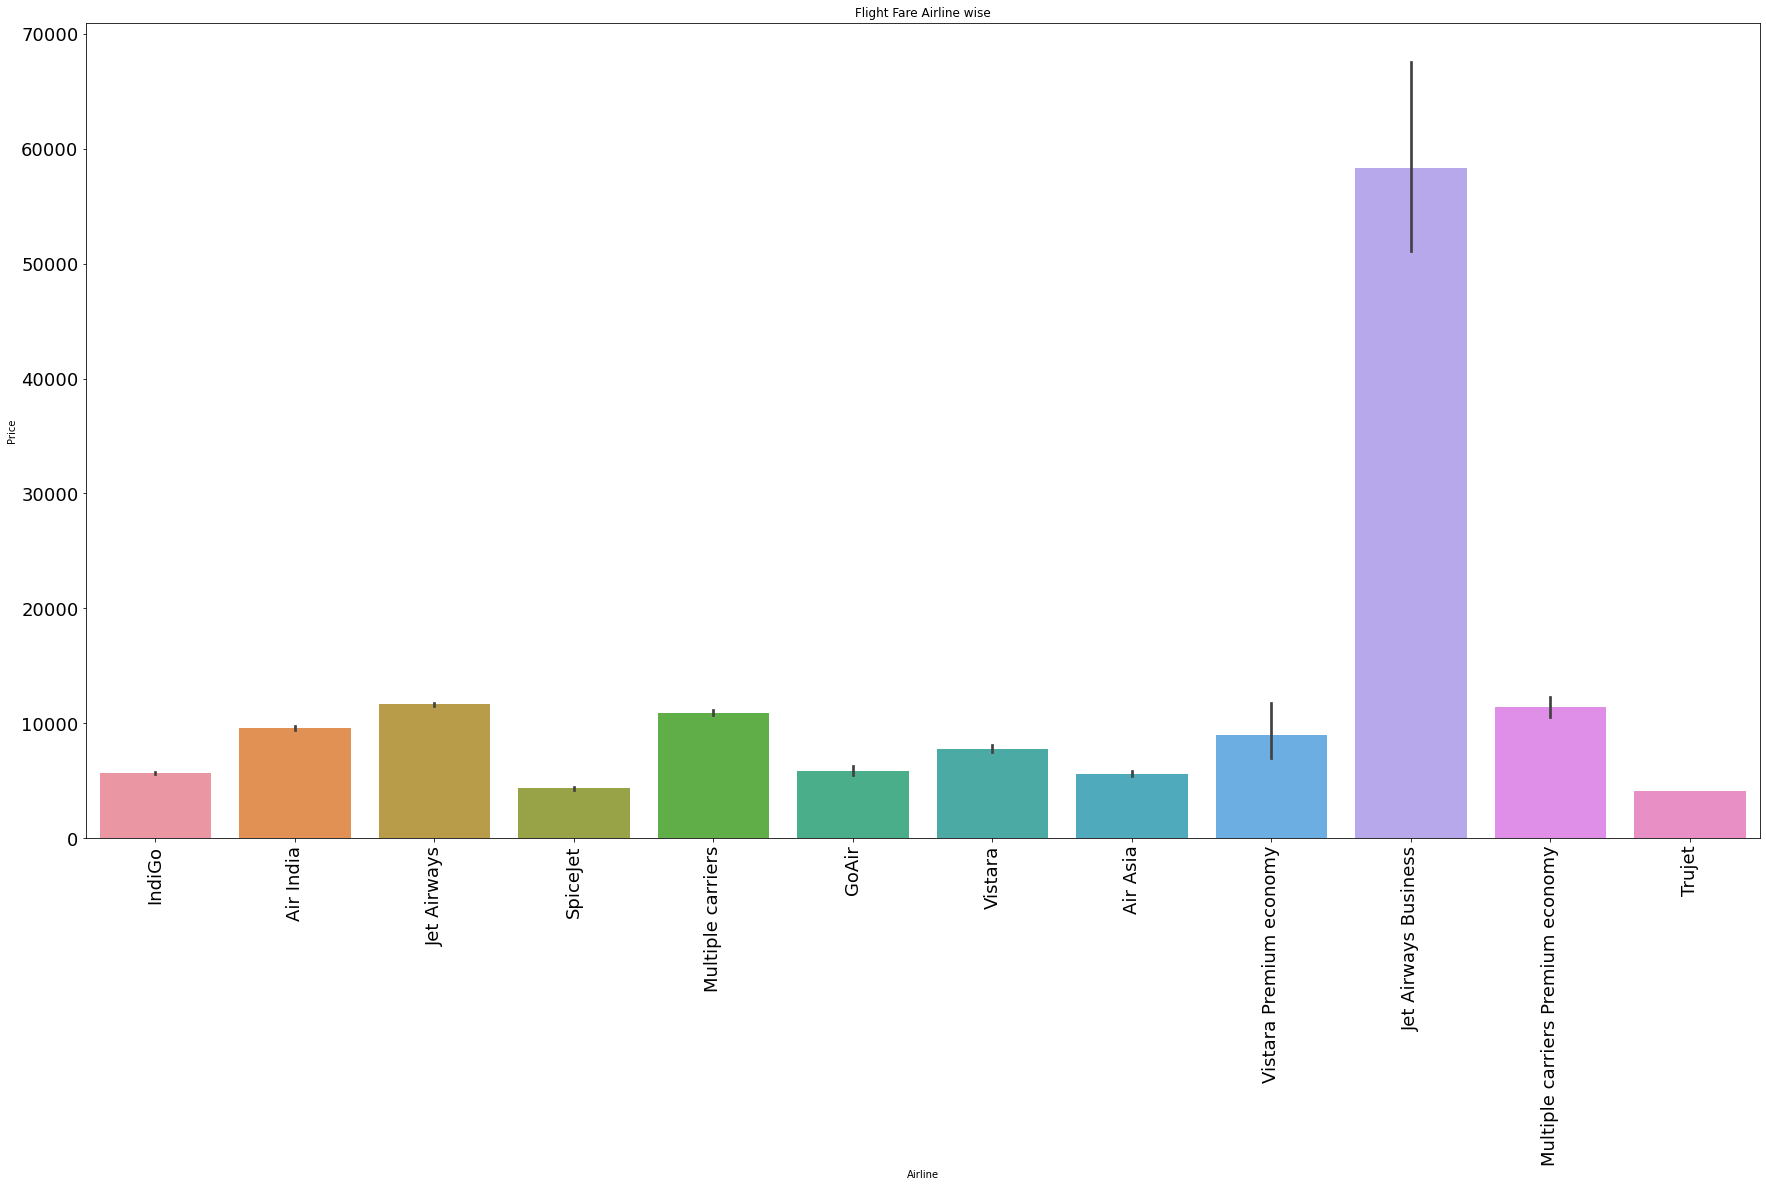

In [22]:
plt.figure(figsize=(30,15))
sns.barplot(x='Airline', y='Price', data=df)
plt.title('Flight Fare Airline wise')
plt.xticks(rotation=90,fontsize=18)
plt.yticks(fontsize=18)

### Obseravtion

1-From above graph i can say that Jet Airways Business has the highest price

2-and spicejet,Indigo,GoAIr,Air Asia is cheap for travel

3-Jet Airways ,Mutiple carriers,Air India have medium price nor high neither low price

In [23]:
df

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Year_of_Journey,Month_of_Journey,Day_of_Journey,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute
0,IndiGo,Banglore,New Delhi,non-stop,No info,3897,2019,3,24,22,20,1,10
1,Air India,Kolkata,Banglore,2 stops,No info,7662,2019,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,2 stops,No info,13882,2019,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,1 stop,No info,6218,2019,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,1 stop,No info,13302,2019,1,3,16,50,21,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,non-stop,No info,4107,2019,9,4,19,55,22,25
10679,Air India,Kolkata,Banglore,non-stop,No info,4145,2019,4,27,20,45,23,20
10680,Jet Airways,Banglore,Delhi,non-stop,No info,7229,2019,4,27,8,20,11,20
10681,Vistara,Banglore,New Delhi,non-stop,No info,12648,2019,1,3,11,30,14,10


# Feature Transformation

In [24]:
oe = OrdinalEncoder()
def ordinal_encoder(df,col):
    df[col] = oe.fit_transform(df[col])
    return df

**Using ordinal encoder because i have features who have values in order**

In [25]:
df=ordinal_encoder(df,['Airline','Source','Destination','Total_Stops','Additional_Info'])

# Spliting data into dependent and independent variable

In [26]:
def preprocess3(df):
    df=df.copy()
    X=df.drop(['Price'], axis=1)
    y=df['Price']
    return X,y

In [27]:
X,y=preprocess3(df)

In [28]:
X

,Airline,Source,Destination,Total_Stops,Additional_Info,Year_of_Journey,Month_of_Journey,Day_of_Journey,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute
0,3.0,0.0,5.0,4.0,8.0,2019,3,24,22,20,1,10
1,1.0,3.0,0.0,1.0,8.0,2019,1,5,5,50,13,15
2,4.0,2.0,1.0,1.0,8.0,2019,9,6,9,25,4,25
3,3.0,3.0,0.0,0.0,8.0,2019,12,5,18,5,23,30
4,3.0,0.0,5.0,0.0,8.0,2019,1,3,16,50,21,35
...,...,...,...,...,...,...,...,...,...,...,...,...
10678,0.0,3.0,0.0,4.0,8.0,2019,9,4,19,55,22,25
10679,1.0,3.0,0.0,4.0,8.0,2019,4,27,20,45,23,20
10680,4.0,0.0,2.0,4.0,8.0,2019,4,27,8,20,11,20
10681,10.0,0.0,5.0,4.0,8.0,2019,1,3,11,30,14,10


In [29]:
y

0         3897
1         7662
2        13882
3         6218
4        13302
         ...  
10678     4107
10679     4145
10680     7229
10681    12648
10682    11753
Name: Price, Length: 10683, dtype: int64

In [30]:
X = X.drop(['Year_of_Journey'], axis=1)    #Dropping this column because it has only one value that is 2019

In [31]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

<AxesSubplot:>

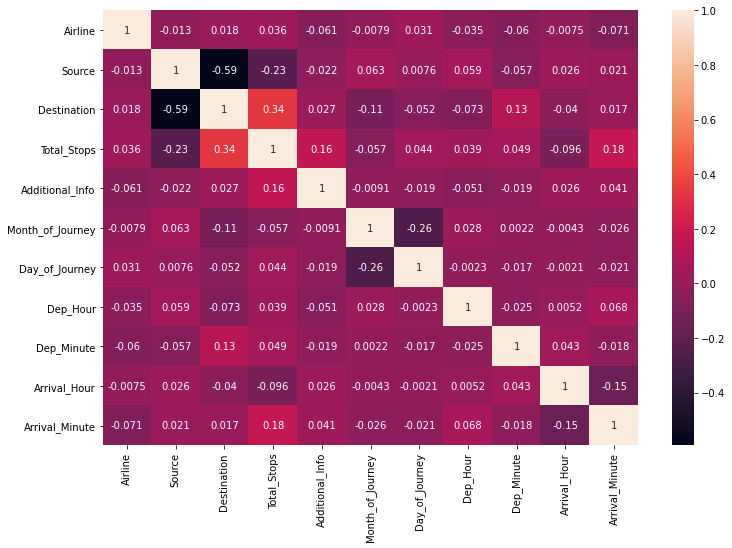

In [32]:
X_corr=X.corr()
plt.figure(figsize=(12,8))
sns.heatmap(X_corr, annot=True)

## Obseravtion

From above graph i can say that most of the columns are having less correlation because most of every column is categorical and through this correlation we can only find correlation with numerical data

### Checking Outliers

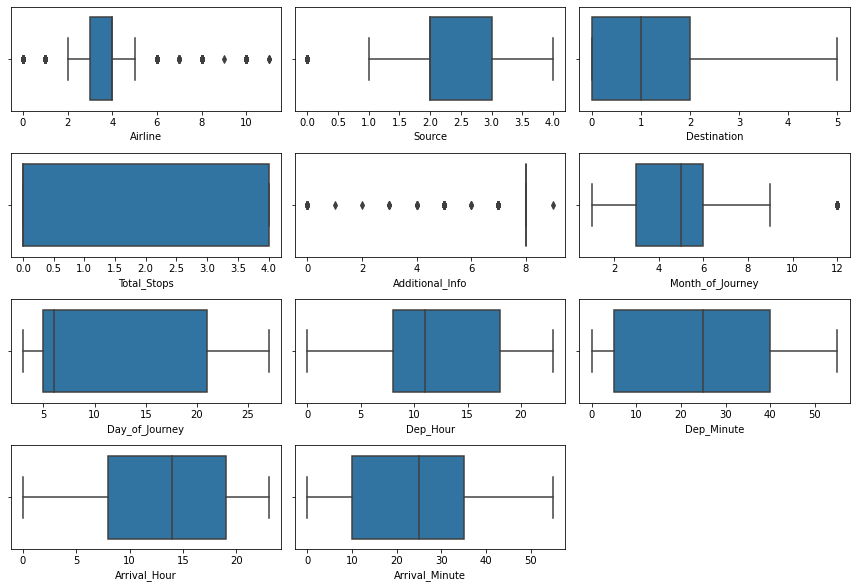

In [33]:
X_val=X.columns.values
plt.figure(figsize=(12,20))
for i in range(len(X_val)):
    plt.subplot(10,3,i+1)
    sns.boxplot(X[X_val[i]], orient='horizonal')
    plt.tight_layout()

# Obseravtion

There is no outliers becouse every column is categorical we dont have any continuous column in X

## Checking SKewness

In [34]:
X.skew()

Airline             0.731095
Source             -0.424054
Destination         1.244169
Total_Stops         0.631681
Additional_Info    -1.779838
Month_of_Journey    0.629540
Day_of_Journey      0.367373
Dep_Hour            0.113073
Dep_Minute          0.167029
Arrival_Hour       -0.369988
Arrival_Minute      0.110945
dtype: float64

# Obseravtion 

There is no skewness because every column is categorical we don't remove skewness of categorical column

# NOTE-

I am not using scaling my features because i am not having any continuous feature in X means in independent feature so my every feature is categorical so no need to scale the features

# Training Multiple models

In [35]:
models={
    "XGB Regressor":XGBRegressor(),
    "ExtraTrees Regressor":ExtraTreesRegressor(),
    "RandomForest Regressor":RandomForestRegressor(),
    "Linear Regression":LinearRegression(),
    "DecisionTree Regressor":DecisionTreeRegressor(),
    "Lasso":Lasso(),
    "LIGHT GBM":LGBMRegressor()
}

__  ______ ____    ____                                         
\ \/ / ___| __ )  |  _ \ ___  __ _ _ __ ___  ___ ___  ___  _ __ 
 \  / |  _|  _ \  | |_) / _ \/ _` | '__/ _ \/ __/ __|/ _ \| '__|
 /  \ |_| | |_) | |  _ <  __/ (_| | | |  __/\__ \__ \ (_) | |   
/_/\_\____|____/  |_| \_\___|\__, |_|  \___||___/___/\___/|_|   
                             |___/                              

MEAN SQUARED ERROR 1832344.7281084755


MEAN ABSOLUTE ERROR 766.3224291725576


CVS_SCORE 0.8960472992208727


R2_SCORE 0.909282805714198


RMSE 1353.6412848714667


MODEL PERFORMANCE CURVE


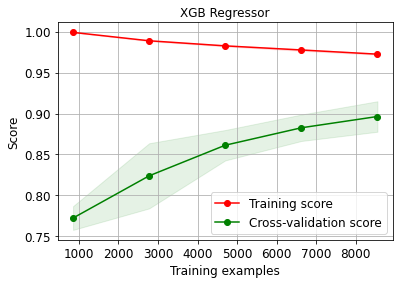

 _____      _            _____                   
| ____|_  _| |_ _ __ __ |_   _| __ ___  ___  ___ 
|  _| \ \/ / __| '__/ _` || || '__/ _ \/ _ \/ __|
| |___ >  <| |_| | | (_| || || | |  __/  __/\__ \
|_____/_/\_\\__|_|  \__,_||_||_|  \___|\___||___/
                                                 
 ____                                         
|  _ \ ___  __ _ _ __ ___  ___ ___  ___  _ __ 
| |_) / _ \/ _` | '__/ _ \/ __/ __|/ _ \| '__|
|  _ <  __/ (_| | | |  __/\__ \__ \ (_) | |   
|_| \_\___|\__, |_|  \___||___/___/\___/|_|   
           |___/                              

MEAN SQUARED ERROR 2017799.1306130039


MEAN ABSOLUTE ERROR 654.291673426937


CVS_SCORE 0.8828333613280025


R2_SCORE 0.9001011802236015


RMSE 1420.492566194207


MODEL PERFORMANCE CURVE


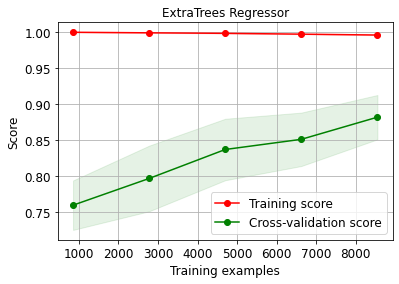

 ____                 _                 _____                   _   
|  _ \ __ _ _ __   __| | ___  _ __ ___ |  ___|__  _ __ ___  ___| |_ 
| |_) / _` | '_ \ / _` |/ _ \| '_ ` _ \| |_ / _ \| '__/ _ \/ __| __|
|  _ < (_| | | | | (_| | (_) | | | | | |  _| (_) | | |  __/\__ \ |_ 
|_| \_\__,_|_| |_|\__,_|\___/|_| |_| |_|_|  \___/|_|  \___||___/\__|
                                                                    
 ____                                         
|  _ \ ___  __ _ _ __ ___  ___ ___  ___  _ __ 
| |_) / _ \/ _` | '__/ _ \/ __/ __|/ _ \| '__|
|  _ <  __/ (_| | | |  __/\__ \__ \ (_) | |   
|_| \_\___|\__, |_|  \___||___/___/\___/|_|   
           |___/                              

MEAN SQUARED ERROR 2069802.4074249747


MEAN ABSOLUTE ERROR 679.9475898595944


CVS_SCORE 0.8820069996959388


R2_SCORE 0.8975265602333338


RMSE 1438.6807871883793


MODEL PERFORMANCE CURVE


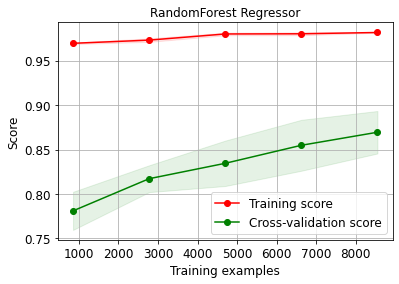

 _     _                       
| |   (_)_ __   ___  __ _ _ __ 
| |   | | '_ \ / _ \/ _` | '__|
| |___| | | | |  __/ (_| | |   
|_____|_|_| |_|\___|\__,_|_|   
                               
 ____                              _             
|  _ \ ___  __ _ _ __ ___  ___ ___(_) ___  _ __  
| |_) / _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ 
|  _ <  __/ (_| | | |  __/\__ \__ \ | (_) | | | |
|_| \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|
           |___/                                 

MEAN SQUARED ERROR 12413993.742844008


MEAN ABSOLUTE ERROR 2609.259938768916


CVS_SCORE 0.36913029831656796


R2_SCORE 0.38539802857137784


RMSE 3523.3497900214234


MODEL PERFORMANCE CURVE


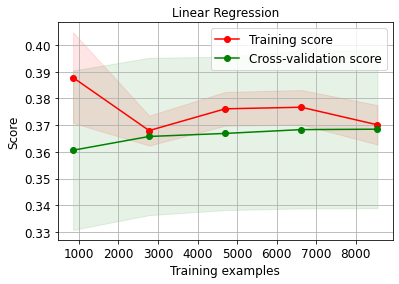

 ____            _     _           _____              
|  _ \  ___  ___(_)___(_) ___  _ _|_   _| __ ___  ___ 
| | | |/ _ \/ __| / __| |/ _ \| '_ \| || '__/ _ \/ _ \
| |_| |  __/ (__| \__ \ | (_) | | | | || | |  __/  __/
|____/ \___|\___|_|___/_|\___/|_| |_|_||_|  \___|\___|
                                                      
 ____                                         
|  _ \ ___  __ _ _ __ ___  ___ ___  ___  _ __ 
| |_) / _ \/ _` | '__/ _ \/ __/ __|/ _ \| '__|
|  _ <  __/ (_| | | |  __/\__ \__ \ (_) | |   
|_| \_\___|\__, |_|  \___||___/___/\___/|_|   
           |___/                              

MEAN SQUARED ERROR 3931303.340838967


MEAN ABSOLUTE ERROR 748.1840873634945


CVS_SCORE 0.7938732030861051


R2_SCORE 0.8053658771210226


RMSE 1982.751457152148


MODEL PERFORMANCE CURVE


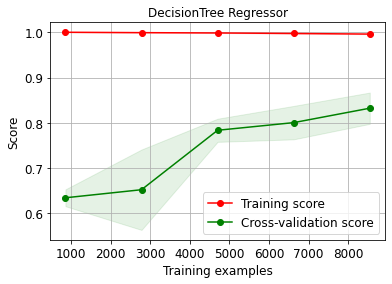

 _                        
| |    __ _ ___ ___  ___  
| |   / _` / __/ __|/ _ \ 
| |__| (_| \__ \__ \ (_) |
|_____\__,_|___/___/\___/ 
                          

MEAN SQUARED ERROR 12413868.25613985


MEAN ABSOLUTE ERROR 2609.2178706471004


CVS_SCORE 0.36878181484361755


R2_SCORE 0.38540424126790096


RMSE 3523.331982107257


MODEL PERFORMANCE CURVE


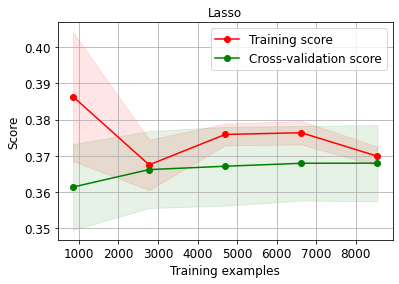

 _     ___ ____ _   _ _____    ____ ____  __  __ 
| |   |_ _/ ___| | | |_   _|  / ___| __ )|  \/  |
| |    | | |  _| |_| | | |   | |  _|  _ \| |\/| |
| |___ | | |_| |  _  | | |   | |_| | |_) | |  | |
|_____|___\____|_| |_| |_|    \____|____/|_|  |_|
                                                 

MEAN SQUARED ERROR 2411596.947038205


MEAN ABSOLUTE ERROR 950.5863594904663


CVS_SCORE 0.8668020797525312


R2_SCORE 0.8806047216839207


RMSE 1552.9317264574786


MODEL PERFORMANCE CURVE


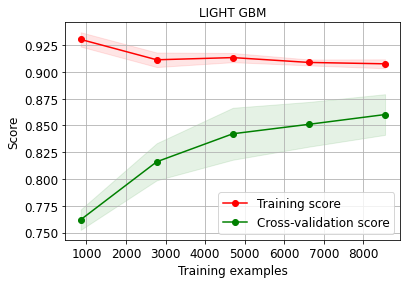

In [36]:
CVS=[]
R2=[]
MSE=[]
MAE=[]
RMSE=[]
NAME=[]
kf=KFold(n_splits=5,shuffle=True)
for name, model in models.items():
  font=pyfiglet.figlet_format(name)
  print(font)
  NAME.append(name)
  model.fit(X_train,y_train)
  y_pred=model.predict(X_test)
  mse=mean_squared_error(y_test,y_pred)
  MSE.append(mse)
  print("MEAN SQUARED ERROR",mse)
  mae=mean_absolute_error(y_test,y_pred)
  MAE.append(mae)
  print('\n')
  print("MEAN ABSOLUTE ERROR",mae)
  cvs=cross_val_score(model,X,y,scoring='r2',cv=kf).mean()
  CVS.append(cvs)
  print('\n')
  print("CVS_SCORE",cvs)
  r2=r2_score(y_test,y_pred)
  R2.append(r2)
  print('\n')
  print("R2_SCORE",r2)
  rmse=np.sqrt(mse)
  RMSE.append(rmse)
  print('\n')
  print("RMSE",rmse)
  print('\n')
  print('MODEL PERFORMANCE CURVE')
  skplt.estimators.plot_learning_curve(model,X,y,cv=kf,scoring='r2',title=name,text_fontsize='large')
  plt.show()

In [37]:
models_result=pd.DataFrame({
    "NAME":NAME,
    "Cross_Val_Score":CVS,
    "R2_score":R2,
    "Mean_squared_error":MSE,
    "Mean_Absolute_Error":MAE,
    "RMSE":RMSE
})

In [38]:
models_result

,NAME,Cross_Val_Score,R2_score,Mean_squared_error,Mean_Absolute_Error,RMSE
0,XGB Regressor,0.896047,0.909283,1.832345e+06,766.322429,1353.641285
1,ExtraTrees Regressor,0.882833,0.900101,2.017799e+06,654.291673,1420.492566
2,RandomForest Regressor,0.882007,0.897527,2.069802e+06,679.947590,1438.680787
3,Linear Regression,0.369130,0.385398,1.241399e+07,2609.259939,3523.349790
4,DecisionTree Regressor,0.793873,0.805366,3.931303e+06,748.184087,1982.751457
5,Lasso,0.368782,0.385404,1.241387e+07,2609.217871,3523.331982
6,LIGHT GBM,0.866802,0.880605,2.411597e+06,950.586359,1552.931726


**I will do hyperparameter Tuning of XGB because it is giving me good CVS and 91% R2 SCore**

In [39]:
XGB=XGBRegressor()

# Hyperparameter Tuning

In [40]:
params = {
    'booster':['gbtree','dart'],
    'importance_type':['gain','split'],
    'max_depth':[6,5,7],
    'n_estimators':[100,200,500]
}

In [41]:
Grid=GridSearchCV(estimator=XGB, param_grid=params, cv=kf, n_jobs=-1, scoring='r2')
Grid.fit(X,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weig...
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    sub

In [42]:
Grid.best_params_

{'booster': 'dart',
 'importance_type': 'gain',
 'max_depth': 6,
 'n_estimators': 200}

In [43]:
Grid.best_score_

0.9028712810802639

**Accuracy increased by 89.60 to 90.28**

In [44]:
XGBR=XGBRegressor(booster = 'dart',
                 importance_type = 'gain',
                 max_depth = 6,
                 n_estimators = 200)

In [45]:
XGBR.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

# Final Model Learning Curve

MODEL PERFORMANCE CURVE


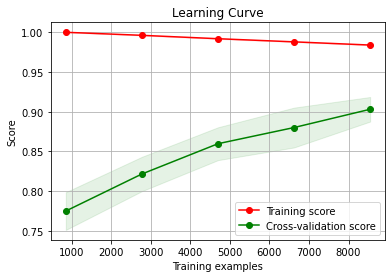

In [46]:
print('MODEL PERFORMANCE CURVE')
skplt.estimators.plot_learning_curve(XGBR, X,y, cv=kf, scoring='r2')
plt.show()

In [47]:
y_pred = XGBR.predict(X_test)

# Final model metrics

In [48]:
print('MSE',mean_squared_error(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))
print('RMSE',np.sqrt(mean_squared_error(y_test,y_pred)))
print('R2_SCORE',r2_score(y_test,y_pred))
print('MODEL SCORE',XGBR.score(X_test,y_test))

MSE 1752025.8986596034
MAE 725.7464340233765
RMSE 1323.6411517702234
R2_SCORE 0.9132592948235606
MODEL SCORE 0.9132592948235606


In [49]:
import joblib
joblib.dump(Grid, 'Flight.obj')

['Flight.obj']

In [50]:
model = joblib.load("C:/Users/Jeet Sarkar/Data Science PG Program/Flight.obj")

In [51]:
model.predict(X_test)

array([10873.832 ,  6057.1963, 14659.062 , ...,  5853.1514,  3314.7197,
       10737.469 ], dtype=float32)

# Loading Test data

In [52]:
df1 = pd.read_excel("C:/Users/Jeet Sarkar/Data Science PG Program/Test_set.xlsx")

In [53]:
df1 = preprocess1(df1)

In [54]:
df1 = preprocess2(df1)

In [55]:
df1 = df1.drop(["Year_of_Journey"], axis=1)

In [56]:
df1 = ordinal_encoder(df1,['Airline','Source','Destination','Total_Stops','Additional_Info'])

In [57]:
df1

,Airline,Source,Destination,Total_Stops,Additional_Info,Month_of_Journey,Day_of_Journey,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute
0,4.0,2.0,1.0,0.0,5.0,6,6,17,30,4,25
1,3.0,3.0,0.0,0.0,5.0,12,5,6,20,10,20
2,4.0,2.0,1.0,0.0,3.0,5,21,19,15,19,0
3,6.0,2.0,1.0,0.0,5.0,5,21,8,0,21,0
4,0.0,0.0,2.0,4.0,5.0,6,24,23,55,2,45
...,...,...,...,...,...,...,...,...,...,...,...
2666,1.0,3.0,0.0,0.0,5.0,6,6,20,30,20,25
2667,3.0,3.0,0.0,4.0,5.0,3,27,14,20,16,55
2668,4.0,2.0,1.0,0.0,5.0,6,3,21,50,4,25
2669,1.0,2.0,1.0,0.0,5.0,6,3,4,0,19,15


# Test data Price prediction

In [58]:
model.predict(df1)

array([10314.657 ,  3901.57  , 11809.94  , ..., 13755.014 , 10818.884 ,
        6586.7534], dtype=float32)

# Conclusion

1-Data was having only one continuous value that was our target column

2-I did EDA to understand the data and written the observation also

3-i did all the preprocessing from data cleaning to data transformation and also did Feature engineering

4-My all columns was categorical so there was no need to remove outliers and skewness and no need to apply scaling also

3-Finally i build a model that was giving me 90% CSV accuracy

4-And finally my model can predict the flight price